Preparation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
import random
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode
from scipy import signal
from sklearn.metrics import mean_squared_error
import csv

In [2]:
import data_corruption

In [3]:
def spect_noise_estimation(spect, qntty, ppm):
  std_array = np.empty(qntty)

  for i in range(qntty):
    idx_noise_1 = np.abs(ppm[i,:] - 8.5).argmin()
    idx_noise_2 = np.abs(ppm[i,:] - 9.5).argmin()
    idx_noise_3 = np.abs(ppm[i,:] - 10.5).argmin()

    #assumes ppm is inverted: smaller values in higher indexes
    ppm_array_1 = ppm[i,idx_noise_2:idx_noise_1]
    ppm_array_2 = ppm[i,idx_noise_3:idx_noise_2]
    spect_array_1 = np.real(spect[i,idx_noise_2:idx_noise_1])
    spect_array_2 = np.real(spect[i,idx_noise_3:idx_noise_2])

    estimate_1 = np.polyfit(ppm_array_1, spect_array_1, 2)
    estimate_2 = np.polyfit(ppm_array_2, spect_array_2, 2)
    aux_1 = (estimate_1[0]*(ppm_array_1**2)) + (estimate_1[1]*ppm_array_1) +  estimate_1[2]
    aux_2 = (estimate_2[0]*(ppm_array_2**2)) + (estimate_2[1]*ppm_array_2) +  estimate_2[2]
    detrending_1 = spect_array_1 - aux_1
    detrending_2 = spect_array_2 - aux_2
    std_1 = np.std(detrending_1)
    std_2 = np.std(detrending_2)

    if np.abs(std_1) < np.abs(std_2):
      std = std_1
    else:
      std = std_2

    std_array[i] = std

  return std_array

def spect_SNR_estimation(spect, qntty, ppm, ppm_min_peak,ppm_max_peak):

  noise_array = spect_noise_estimation(spect, qntty, ppm)
  SNR_array = np.empty(qntty)
  peak_array = np.empty(qntty)

  for i in range(qntty):
    idx_GABA_0 = np.abs(ppm[i,:] - ppm_min_peak).argmin()
    idx_GABA_1 = np.abs(ppm[i,:] - ppm_max_peak).argmin()
    peak_amplitude = np.max(np.abs(np.real(spect[i,idx_GABA_1:idx_GABA_0])))

    SNR = peak_amplitude/(2*noise_array[i])
    SNR_array[i] = SNR
    peak_array[i] = peak_amplitude

  return SNR_array, noise_array, peak_array

In [4]:
def normalize_vector_between_minus_one_and_one(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = (((real_parts - min_real)/range_real)*2)-1
    normalized_imaginary = (((imaginary_parts - min_imaginary)/range_imaginary)*2)-1

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def get_normalized_spectrogram(fids,bandwidth,qntty,a,b,norm_abs,correct_time):
    w = hann(256, sym=True)
    mfft_ = 446
    SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i,:])
        if norm_abs == True:
            spgram.append(aux/np.max(np.abs(aux)))
        else:
            spgram.append(normalize_vector_between_minus_one_and_one(aux))
    spgram = np.array(spgram)
    
    freq_spect = np.flip(np.linspace(f_lo,f_hi,mfft_))
    ppm_spect = a*freq_spect+b
    t_spect = np.linspace(t_lo,t_hi,spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:,:,zero_idx:one_idx]
    
    return spgram, freq_spect, ppm_spect, t_spect

In [5]:
def get_grad(img_array):

    if len(img_array.shape) == 3:
        grad_array = np.zeros((img_array.shape[0],2,img_array.shape[1],img_array.shape[2]))
        for i in range(img_array.shape[1]-1):
            grad_array[:,0,i,:] = img_array[:,i+1,:]-img_array[:,i,:]
        for j in range(img_array.shape[2]-1):
            grad_array[:,1,:,j] = img_array[:,:,j+1]-img_array[:,:,j]
            
    elif len(img_array.shape) == 2:
        grad_array = np.zeros((2,img_array.shape[0],img_array.shape[1]))
        for i in range(img_array.shape[0]-1):
            grad_array[0,i,:] = img_array[i+1,:]-img_array[i,:]
        for j in range(img_array.shape[1]-1):
            grad_array[1,:,j] = img_array[:,j+1]-img_array[:,j]
            
    return grad_array

In [6]:
def get_div(grad_array):

    if len(grad_array.shape) == 4:
        w_1 = np.empty((grad_array.shape[0],grad_array.shape[2],grad_array.shape[3]))
        w_2 = np.empty((grad_array.shape[0],grad_array.shape[2],grad_array.shape[3]))
        w_1[:,0,:] = grad_array[:,0,0,:]
        w_1[:,-1,:] = -grad_array[:,0,-2,:]
        w_2[:,:,0] = grad_array[:,1,:,0]
        w_2[:,:,-1] = -grad_array[:,1,:,-2]
        for i in range(1,grad_array.shape[2]-1):
            w_1[:,i,:] = grad_array[:,0,i,:]-grad_array[:,0,i-1,:]
        for j in range(1,grad_array.shape[3]-1):
            w_2[:,:,j] = grad_array[:,1,:,j]-grad_array[:,1,:,j-1]
    elif len(grad_array.shape) == 3:
        w_1 = np.empty((grad_array.shape[1],grad_array.shape[2]))
        w_2 = np.empty((grad_array.shape[1],grad_array.shape[2]))
        w_1[0,:] = grad_array[0,0,:]
        w_1[-1,:] = -grad_array[0,-2,:]
        w_2[:,0] = grad_array[1,:,0]
        w_2[:,-1] = -grad_array[1,:,-2]
        for i in range(1,grad_array.shape[2]-1):
            w_1[i,:] = grad_array[0,i,:]-grad_array[0,i-1,:]
        for j in range(1,grad_array.shape[3]-1):
            w_2[:,j] = grad_array[1,:,j]-grad_array[1,:,j-1]

    return w_1 + w_2

In [7]:
def get_TV(img_array):
    grad = get_grad(img_array)
    if len(img_array.shape) == 3:
        TV = np.sum(np.abs(grad[:,0,:,:]) + np.abs(grad[:,1,:,:]),axis=(1,2))
        TV = np.mean(TV)
    elif len(img_array.shape) == 2:
        TV = np.sum(np.abs(grad[0,:,:]) + np.abs(grad[1,:,:]))
    return TV

In [8]:
def get_Norml2(img_array,x):
    if len(img_array.shape) == 3:
        return np.mean(np.linalg.norm(np.matmul((img_array - x),np.conjugate((img_array - x).transpose(0,2,1))),ord=2,axis = (1,2)))
    elif len(img_array.shape) == 2:
        return np.linalg.norm(np.matmul((img_array - x),np.conjugate((img_array - x).transpose(1,0))),ord=2)

In [9]:
def min_TV(img_array, tau,lamda,nmb_ite):

    TV = []
    Norm = []
    if len(img_array.shape) == 3:
        u = np.zeros((img_array.shape[0],2,img_array.shape[1],img_array.shape[2]))
    elif len(img_array.shape) == 2:
        u = np.zeros((2,img_array.shape[0],img_array.shape[1]))
        
    for i in range(nmb_ite):
        div = get_div(u)
        u_up_intermediate = u + tau*get_grad(div+img_array)
        u = np.clip(u_up_intermediate,-lamda,lamda)
        TV.append(get_TV(img_array + get_div(u)))
        #Norm.append(get_Norml2(img_array,img_array + get_div(u)))
   
    #Norm.append(get_Norml2(img_array,img_array + get_div(u)))    
    return img_array + get_div(u),TV, Norm

In [10]:
def read_data(file_path):
  # Add new data to CSV file
    std = []
    var = []
    lamda = []
    tv = []
    mse = []
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file, delimiter=',')
        line_count = 0
        for row in reader:
            if line_count != 0:
                aux = [float(i) for i in row]
                std.append(aux[0])
                var.append(aux[1])
                lamda.append(aux[2])
                aux2 = []
                for i in range(50):
                    aux2.append(aux[i+3])
                tv.append(aux2)
                mse.append(aux[-1])
            line_count += 1
            
    return std,var,lamda,tv,mse

In [11]:
def read_data_noise(file_path):
  # Add new data to CSV file
    std = []
    var = []
    dict_metrics = {}
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file, delimiter=',')
        line_count = 0
        for row in reader:
            if line_count == 0:
                head = (row[0].strip('][').split(', '))[2:]
                aux = (row[1].strip('][').split(', '))
                for i in range(0,len(head),2):
                    dict_metrics[str(head[i][6:-1])] = {'mean':[],'std':[]}
            else:
                aux = (row[0].strip('][').split(', '))
            aux2 = [float(i) for i in aux]
            std.append(aux2[0])
            var.append(aux2[1])
            for i in range(0,len(head),2):
                dict_metrics[str(head[i][6:-1])]['mean'].append(aux2[i+2])
                dict_metrics[str(head[i][6:-1])]['std'].append(aux2[i+3])
            line_count += 1
            
    return std,var,dict_metrics

In [12]:
def create_corrupted_fids(gt,std_base,std_var):
  tm = data_corruption.TransientMaker(gt_fids,t,transients=160)
  tm.add_random_amplitude_noise(std_base,std_var)
  corrupted_fids = tm.fids

  return corrupted_fids

In [13]:
std_,var_,lamda_,tv_,mse_ = read_data('tv_correct.csv')

In [14]:
std3_,var3_,lamda3_,tv3_,mse3_ = read_data('tv_complete.csv')

In [15]:
std_basis = [1,2,3,4,5,6,7,8,9,10,12,15,17,19]

In [16]:
std_estimated_for_residual = []
for i in range(len(std_)):
    if i%20 == 0:
        std_estimated_for_residual.append(lamda_[i])

In [17]:
min_mse_idx = []
for i in range(len(std_basis)):
    aux = mse3_[i*26:(i+1)*26]
    min_mse_idx.append(aux.index(min(aux)))
lamda_min_mse = []
min_mse = []
for i in range(len(std_basis)):
    aux = lamda3_[i*26:(i+1)*26]
    aux2 = mse3_[i*26:(i+1)*26]
    lamda_min_mse.append(aux[min_mse_idx[i]])
    min_mse.append(aux2[min_mse_idx[i]])

In [18]:
std_aux,var_aux,dict_metrics_normABS_tcorrected = read_data_noise('data_Real_Norm_ABS_STFT_FID_spgram_timecorrected.csv')

Text(0.5, 0, 'noise level')

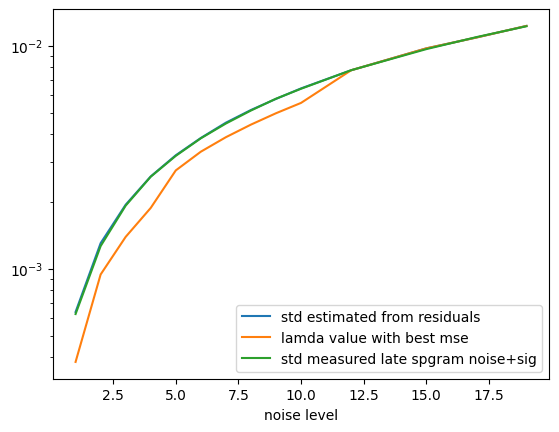

In [19]:
plt.plot(std_basis,std_estimated_for_residual, label = 'std estimated from residuals')
plt.plot(std_basis,lamda_min_mse, label = 'lamda value with best mse')
#plt.plot(std_basis,dict_metrics_normABS_tcorrected['STD_total']['mean'], label ='std measured spgram noise+sig')
plt.plot(std_basis,dict_metrics_normABS_tcorrected['STD_late']['mean'], label ='std measured late spgram noise+sig')
#plt.plot(std_basis,dict_metrics_normABS_tcorrected['STD_main_sig']['mean'], label ='std measured main part spgram noise+sig')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlabel('noise level')

Text(0.5, 0, 'noise level')

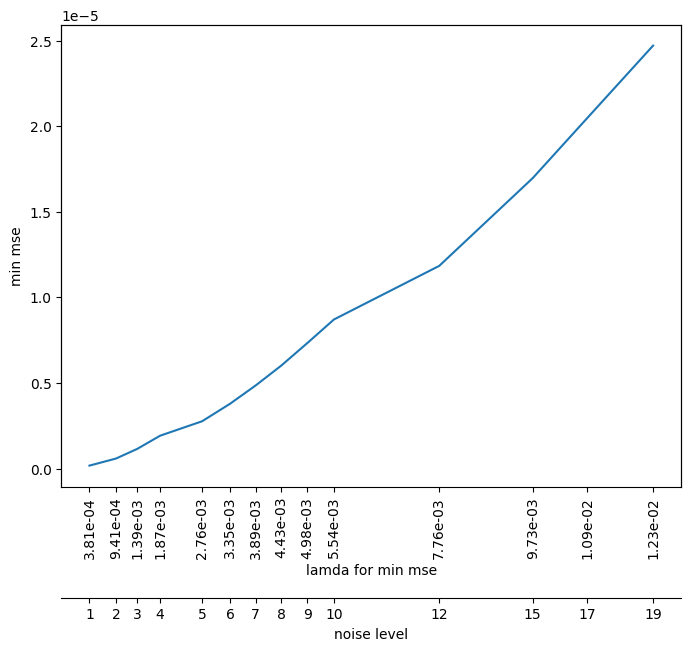

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.plot(lamda_min_mse,min_mse)
secondary_ticks = lamda_min_mse
ax.set_xlabel('lamda for min mse')
ax.set_ylabel('min mse')
ax.set_xticks(secondary_ticks)
primary_labels = ["{:.2e}".format(value) for value in lamda_min_mse]
ax.set_xticklabels(primary_labels)
for label in ax.get_xticklabels():
    label.set_rotation(90)

ax_aux2 = ax.twiny()
ax_aux2.spines['bottom'].set_position(('outward', 80))
ax_aux2.xaxis.set_ticks_position('bottom')
ax_aux2.xaxis.set_label_position('bottom')
secondary_labels = [str(i) for i in std_basis]
ax_aux2.set_xlim(ax.get_xlim())
secondary_ticks = ax.get_xticks()
ax_aux2.set_xticks(secondary_ticks)
ax_aux2.set_xticklabels(secondary_labels)
ax_aux2.set_xlabel('noise level')

Text(0, 0.5, 'mse')

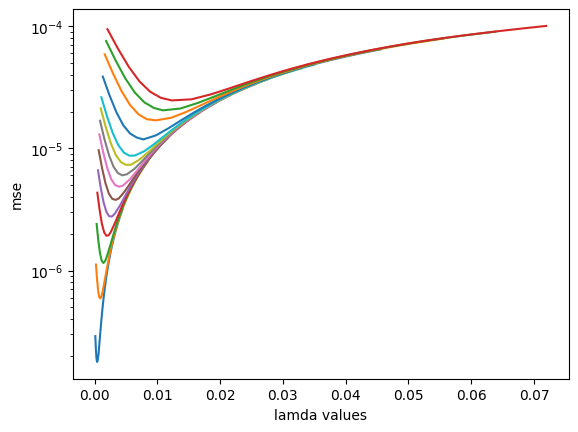

In [21]:
for i in range(len(std_basis)):
    plt.plot(lamda3_[i*26:(i+1)*26],mse3_[i*26:(i+1)*26])
plt.yscale('log')
plt.xlabel('lamda values')
plt.ylabel('mse')

In [22]:
qntty = 1

In [23]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(1, 2048, 2)
(1, 2048)
(1, 2048)


In [24]:
#general
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]
nmb_ite = 50

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

#spgram gt
spgram_gt, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth,qntty,a,b,True,True)


std_basis = [1,2,3,4,5,6,7,8,9,10,12,15,17,19]
var_basis = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5]

print('starting process...')

TV_global = []
mse_global = []
spgrams_corrupted = []
spgrams_filtered = [] 
residuals = []

for level_idx in range(len(std_basis)):
    corrupted_fids = create_corrupted_fids(gt_fids,std_basis[level_idx],var_basis[level_idx])
    #spectrogram
    corrupted_fids_avgs = np.mean((corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:]), axis = 2)
    spgram_corrupted_avgs, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(corrupted_fids_avgs,bandwidth,qntty,a,b,True,True)
    spgrams_corrupted.append(np.real(spgram_corrupted_avgs))

    residuals.append(np.real(spgram_corrupted_avgs)-np.real(spgram_gt))
    filtered_TV, TV_aux, Norm_aux = min_TV(np.real(spgram_corrupted_avgs),0.25,lamda_min_mse[level_idx],nmb_ite)
    spgrams_filtered.append(filtered_TV)
    TV_global.append(TV_aux)
    mse_global.append(mean_squared_error(np.real(spgram_gt)[0,:,:], filtered_TV[0,:,:]))
        
    print('done: '+str(level_idx+1)+'/'+str(len(std_basis)))

starting process...
done: 1/14
done: 2/14
done: 3/14
done: 4/14
done: 5/14
done: 6/14
done: 7/14
done: 8/14
done: 9/14
done: 10/14
done: 11/14
done: 12/14
done: 13/14
done: 14/14


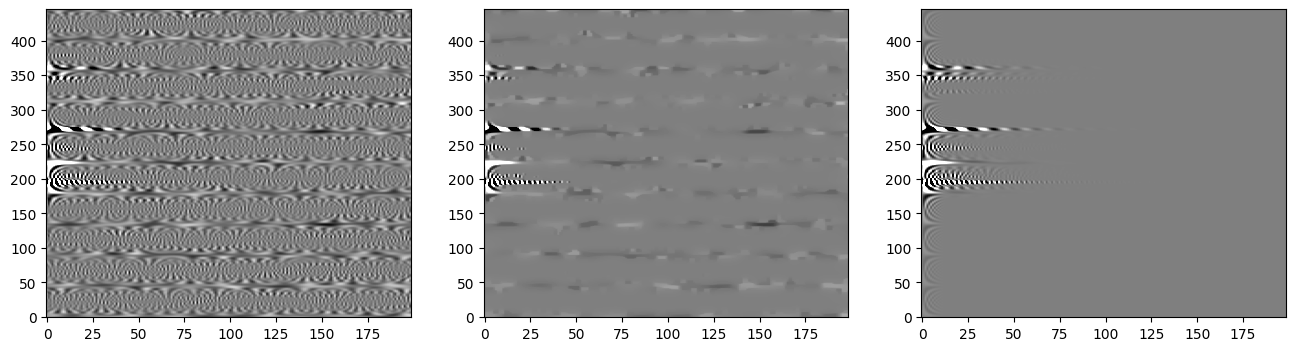

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
vmin_ = np.mean(np.real(spgram_gt[0,:,:]))-2*np.std(np.real(spgram_gt[0,:,:]))
vmax_ = np.mean(np.real(spgram_gt[0,:,:]))+2*np.std(np.real(spgram_gt[0,:,:]))

ax[0].imshow(spgrams_corrupted[-1][0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[1].imshow(spgrams_filtered[-1][0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[2].imshow(np.real(spgram_gt[0,:,:]), origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)

Text(0.5, 0, 'noise level')

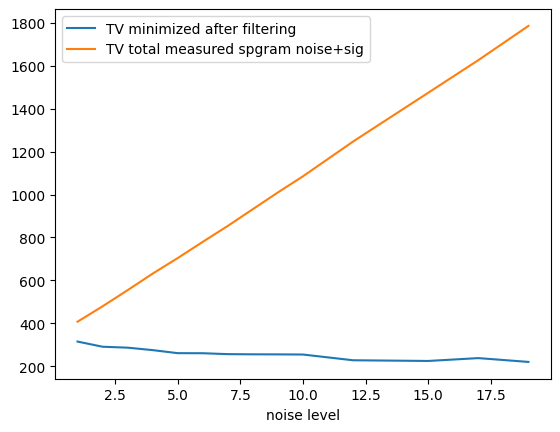

In [47]:
aux = []
for i in range(len(TV_global)):
    aux.append(TV_global[i][-1])
plt.plot(std_basis,aux, label = 'TV minimized after filtering')
plt.plot(std_basis,dict_metrics_normABS_tcorrected['TV_aniso_total']['mean'], label ='TV total measured spgram noise+sig')
plt.legend(loc='upper left')
plt.xlabel('noise level')

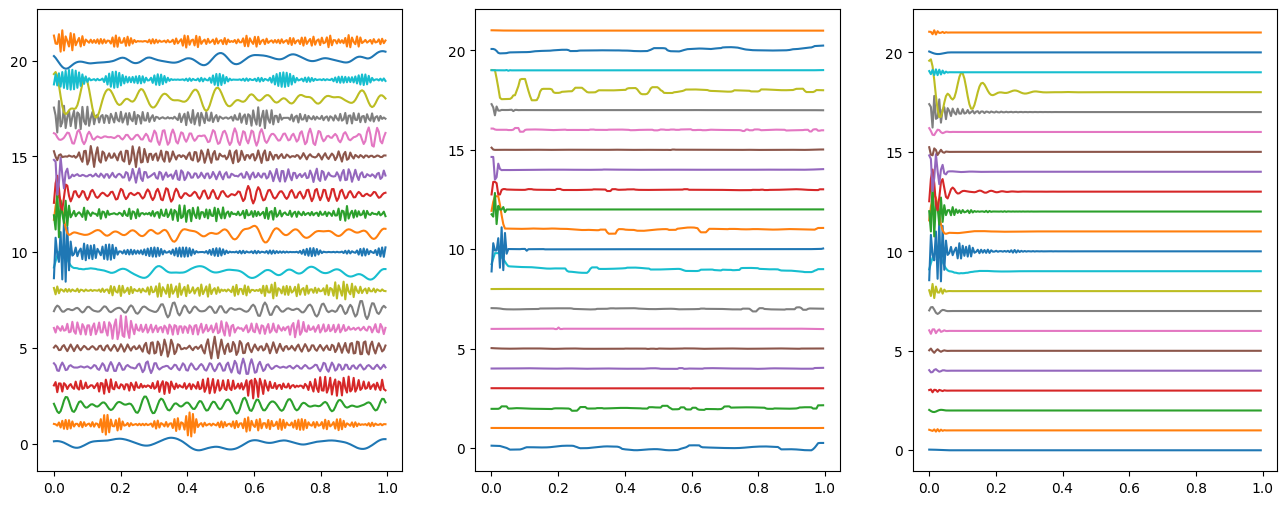

In [39]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
offset = 1
for i in range(int(np.round(spgram_gt.shape[1]/20))):
    ax[0].plot(t_spect,spgrams_corrupted[-1][0,i*20,:]*20+offset*i)
    ax[1].plot(t_spect,spgrams_filtered[-1][0,i*20,:]*20+offset*i)
    ax[2].plot(t_spect,np.real(spgram_gt[0,i*20,:])*20+offset*i)

In [15]:
file_tv = 'tv_complete.csv'
nmb_ite = 50
data_tv = []
data_tv.append('std_base')
data_tv.append('var')
data_tv.append('lamda')
for j in range(nmb_ite):
    data_tv.append('tv_'+str(j))
data_tv.append('mse')
write_data(file_tv, data_tv)

for i in range(len(std_basis)):
    for k in range(6):
        data_tv = []
        data_tv.append(std2_[k+6*i])
        data_tv.append(var2_[k+6*i])
        data_tv.append(lamda2_[k+6*i])
        for j in range(nmb_ite):
            data_tv.append(tv2_[k+6*i][j])
        data_tv.append(mse2_[k+6*i])
        write_data(file_tv, data_tv)
    for k in range(20):
        data_tv = []
        data_tv.append(std_[k+20*i])
        data_tv.append(var_[k+20*i])
        data_tv.append(lamda_[k+20*i])
        for j in range(nmb_ite):
            data_tv.append(tv_[k+20*i][j])
        data_tv.append(mse_[k+20*i])
        write_data(file_tv, data_tv)